<a href="https://colab.research.google.com/github/DioSurreal/Machine_Learning_End_to_End_NLP_Spotify_Project/blob/master/nlp_sentiment_analysis_spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import WordCloud # for word cloud generation
from collections import Counter # for calculating the frequency of elements in a collection.
from bertopic import BERTopic


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import joblib



from zipfile import ZipFile


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
!kaggle datasets download -d alexandrakim2201/spotify-dataset

Dataset URL: https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/2.90M [00:00<?, ?B/s]
100% 2.90M/2.90M [00:00<00:00, 162MB/s]


In [ ]:
!unzip spotify-dataset.zip

Archive:  spotify-dataset.zip
  inflating: DATASET.csv             


In [ ]:
df = pd.read_csv('DATASET.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


In [ ]:
df_1 = df.copy()
df_1.columns = df_1.columns.str.lower()
df_1.head()

,review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE


In [ ]:
df_1.isnull().sum()

,0
review,16
label,0


In [ ]:
df_1 = df_1.dropna(subset=['review'])
df_1.isnull().sum()

,0
review,0
label,0


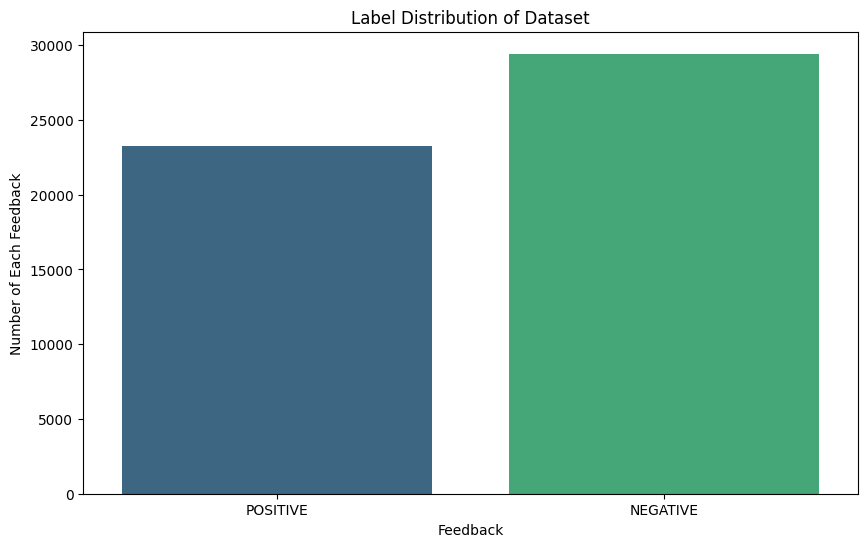

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df_1['label'], data = df_1, palette='viridis')
plt.title('Label Distribution of Dataset')
plt.xlabel('Feedback')
plt.ylabel('Number of Each Feedback')
plt.show()

In [ ]:
def text_cleaning(text):
    text = re.sub(r'Ã[\x80-\xBF]+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text.lower()

In [ ]:
df_1['review'] = df_1['review'].apply(text_cleaning)

In [ ]:
def tokenize_text(text):
    token = word_tokenize(text)
    return token

In [ ]:
df_1['token'] = df_1['review'].apply(tokenize_text)

In [ ]:
df_1.head()

,review,label,token
0,great music service the audio is high quality ...,POSITIVE,"[great, music, service, the, audio, is, high, ..."
1,please ignore previous negative rating this ap...,POSITIVE,"[please, ignore, previous, negative, rating, t..."
2,this pop up get the best spotify experience on...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper..."
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of..."
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ..."


remove stopwords

In [ ]:
custom_stopwords = {'app', 'spotify', 'listen','please'}

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    return [word for word in tokens if word.lower() not in stop_words]

In [ ]:
df_1['no_stopwords_tokens'] = df_1['token'].apply(remove_stopwords)
df_1.head(10)

,review,label,token,no_stopwords_tokens
0,great music service the audio is high quality ...,POSITIVE,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating this ap...,POSITIVE,"[please, ignore, previous, negative, rating, t...","[ignore, previous, negative, rating, super, gr..."
2,this pop up get the best spotify experience on...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, experience, android, 12, anno..."
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, get, songs, put, playlist, shuffle, play]"
5,the player controls sometimes disappear for no...,NEGATIVE,"[the, player, controls, sometimes, disappear, ...","[player, controls, sometimes, disappear, reaso..."
6,i love the selection and the lyrics are provid...,POSITIVE,"[i, love, the, selection, and, the, lyrics, ar...","[love, selection, lyrics, provided, song, list..."
7,still extremely slow when changing storage to ...,NEGATIVE,"[still, extremely, slow, when, changing, stora...","[still, extremely, slow, changing, storage, ex..."
8,it s a great app and the best mp3 music app i ...,POSITIVE,"[it, s, a, great, app, and, the, best, mp3, mu...","[great, best, mp3, music, ever, used, one, pro..."
9,i m deleting this app for the following reason...,NEGATIVE,"[i, m, deleting, this, app, for, the, followin...","[deleting, following, reasons, failing, busine..."


In [ ]:
# โหลด WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# ฟังก์ชัน Lemmatization
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# ใช้ Lemmatization กับทุกแถวใน DataFrame
df_1['lemmatized_tokens'] = df_1['no_stopwords_tokens'].apply(lemmatize_tokens)

df_1.head()

,review,label,token,no_stopwords_tokens,lemmatized_tokens
0,great music service the audio is high quality ...,POSITIVE,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ...","[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating this ap...,POSITIVE,"[please, ignore, previous, negative, rating, t...","[ignore, previous, negative, rating, super, gr...","[ignore, previous, negative, rating, super, gr..."
2,this pop up get the best spotify experience on...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, experience, android, 12, anno...","[pop, get, best, experience, android, 12, anno..."
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, get, songs, put, playlist, shuffle, play]","[dear, get, song, put, playlist, shuffle, play]"


analysis

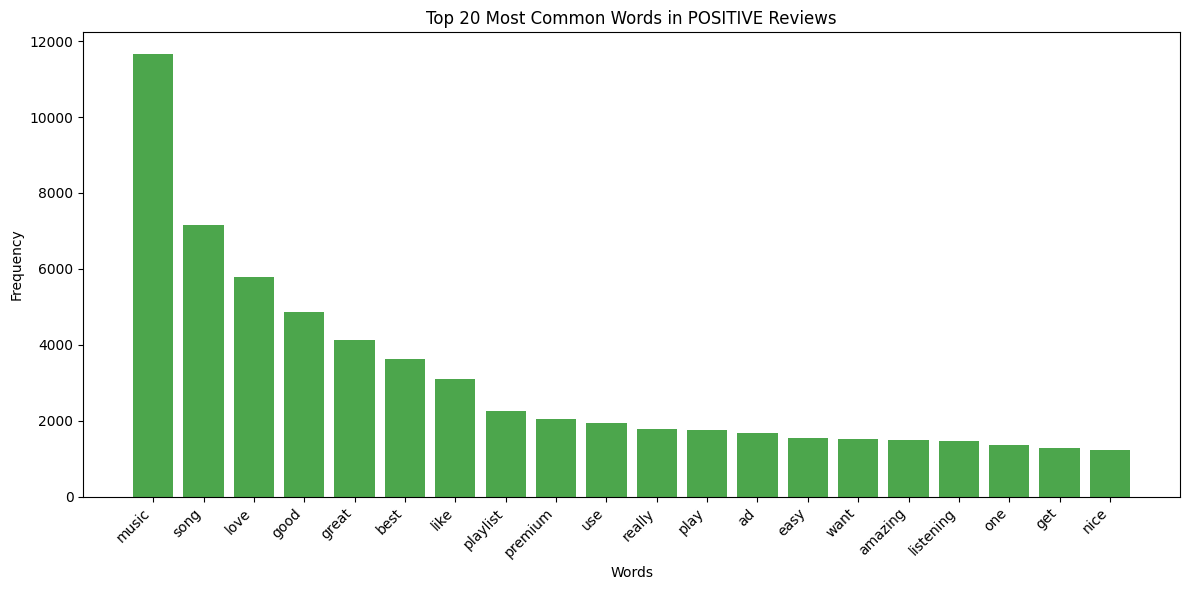

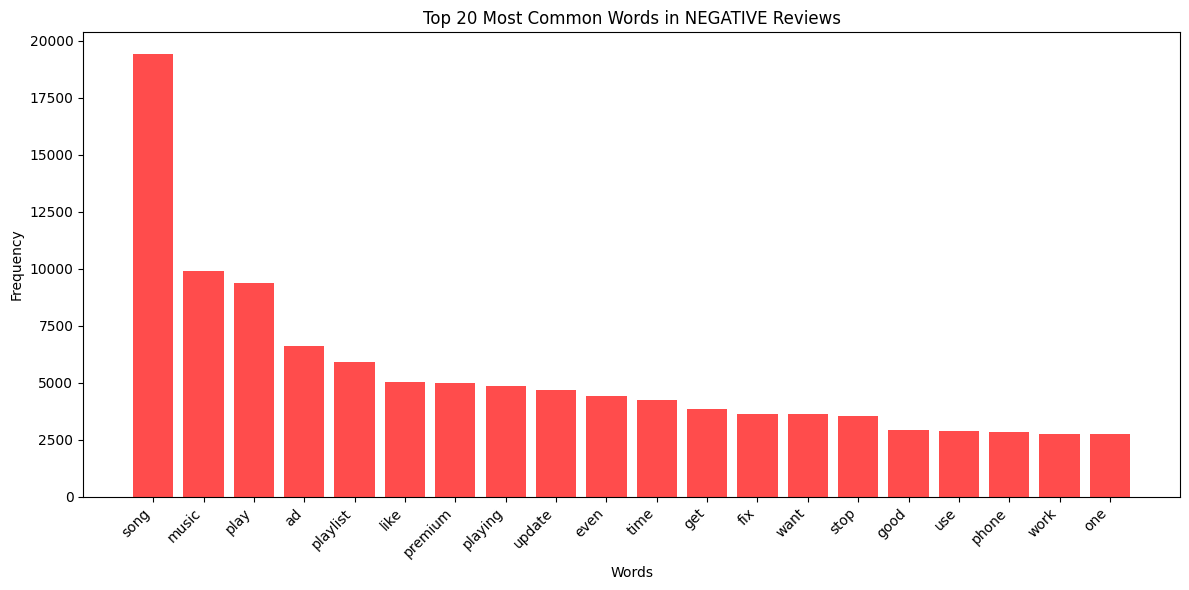

In [ ]:
# แยกคำในแต่ละ label
pos_df_1 = df_1[df_1['label'] == 'POSITIVE']
neg_df_1 = df_1[df_1['label'] == 'NEGATIVE']

# นับคำในแต่ละ label
pos_before_count = [word for tokens in pos_df_1['lemmatized_tokens'] for word in tokens]
neg_before_count = [word for tokens in neg_df_1['lemmatized_tokens'] for word in tokens]

# ใช้ Counter เพื่อหาคำที่พบบ่อยที่สุด
pos_word_counts = Counter(pos_before_count)
neg_word_counts = Counter(neg_before_count)

# ดึงคำที่พบบ่อยที่สุด 20 อันดับ
most_common_pos = pos_word_counts.most_common(20)
most_common_neg = neg_word_counts.most_common(20)

# แยกคำและจำนวนสำหรับการ plot
pos_words, pos_counts = zip(*most_common_pos)
neg_words, neg_counts = zip(*most_common_neg)

# Plot กราฟแท่งสำหรับ POSITIVE
plt.figure(figsize=(12, 6))
plt.bar(pos_words, pos_counts, color='green', alpha=0.7)
plt.title('Top 20 Most Common Words in POSITIVE Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot กราฟแท่งสำหรับ NEGATIVE
plt.figure(figsize=(12, 6))
plt.bar(neg_words, neg_counts, color='red', alpha=0.7)
plt.title('Top 20 Most Common Words in NEGATIVE Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# # เตรียมข้อมูลข้อความ (Filtered_Tokens)
pos_doc = pos_df_1['lemmatized_tokens'].tolist()
neg_doc = neg_df_1['lemmatized_tokens'].tolist()


# แปลง Tokens กลับเป็นข้อความ (สำหรับ POSITIVE และ NEGATIVE)
pos_text = [" ".join(tokens) for tokens in pos_doc]  # ข้อความจาก POSITIVE
neg_text = [" ".join(tokens) for tokens in neg_doc]  # ข้อความจาก NEGATIVE

# สำหรับ POSITIVE Reviews
topic_model_pos = BERTopic()
pos_topics, pos_probs = topic_model_pos.fit_transform(pos_text)
# แสดงหัวข้อที่ค้นพบจาก POSITIVE
print("POSITIVE Topics Info:")
print(topic_model_pos.get_topic_info())



# สำหรับ NEGATIVE Reviews
topic_model_neg = BERTopic()
neg_topics, neg_probs = topic_model_neg.fit_transform(neg_text)
# แสดงหัวข้อที่ค้นพบจาก NEGATIVE
print("NEGATIVE Topics Info:")
print(topic_model_neg.get_topic_info())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

POSITIVE Topics Info:
     Topic  Count                                               Name  \
0       -1   7421                             -1_song_like_love_play   
1        0   1132                   0_podcasts_podcast_also_favorite   
2        1    713                        1_playlist_list_create_make   
3        2    691                           2_premium_worth_pay_plan   
4        3    674                        3_ad_commercial_annoying_30   
..     ...    ...                                                ...   
281    280     10           280_recommand_thst_powerful_unbelievable   
282    281     10        281_distractable_problem_whatsoever_despite   
283    282     10                             282_tom_ever_yous_seen   
284    283     10  283_awesomeness_fabulous_awesomenever_overwhel...   
285    284     10  284_wichall_kl_goodddddddddddddddddddddddddddd...   

                                        Representation  \
0    [song, like, love, play, playlist, new, featur... 

In [ ]:
topic_model_pos.visualize_topics()

In [ ]:
topic_model_neg.visualize_topics()

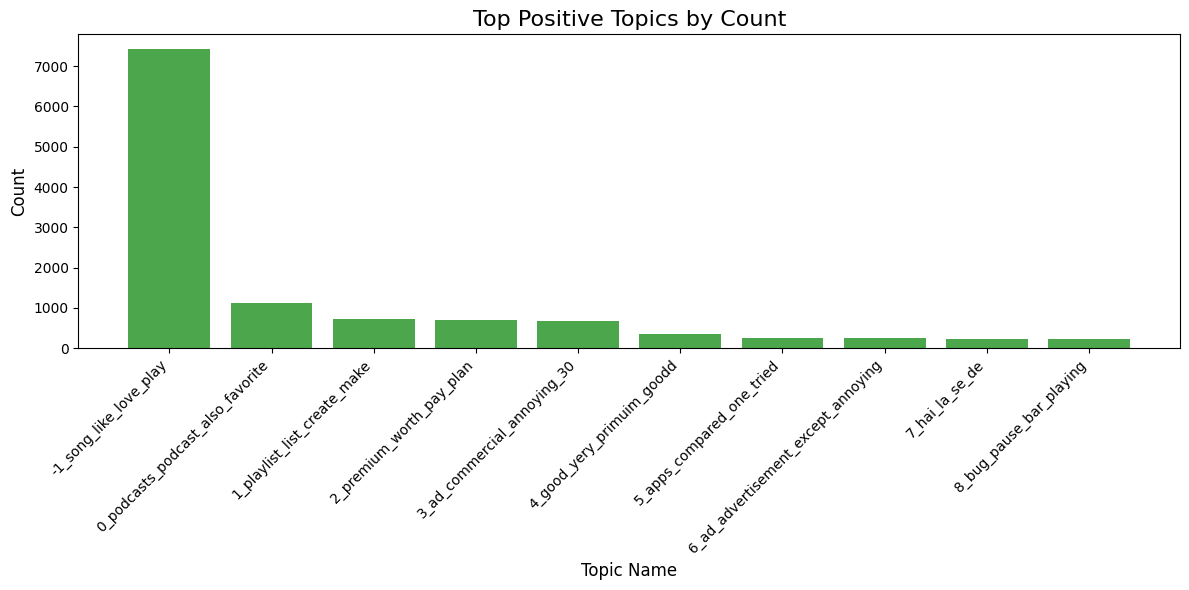

In [ ]:
positive_topics_info = topic_model_pos.get_topic_info()
negative_topics_info = topic_model_neg.get_topic_info()


# เลือกจำนวนหัวข้อที่ต้องการแสดง
top_n = 10  # จำนวนหัวข้อที่ต้องการแสดง (10 อันดับแรก)
positive_topics = positive_topics_info.head(top_n)
negative_topics = negative_topics_info.head(top_n)


# Plot สำหรับ POSITIVE reviews
plt.figure(figsize=(12, 6))
plt.bar(positive_topics['Name'], positive_topics['Count'], color='green', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.title('Top Positive Topics by Count', fontsize=16)
plt.xlabel('Topic Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

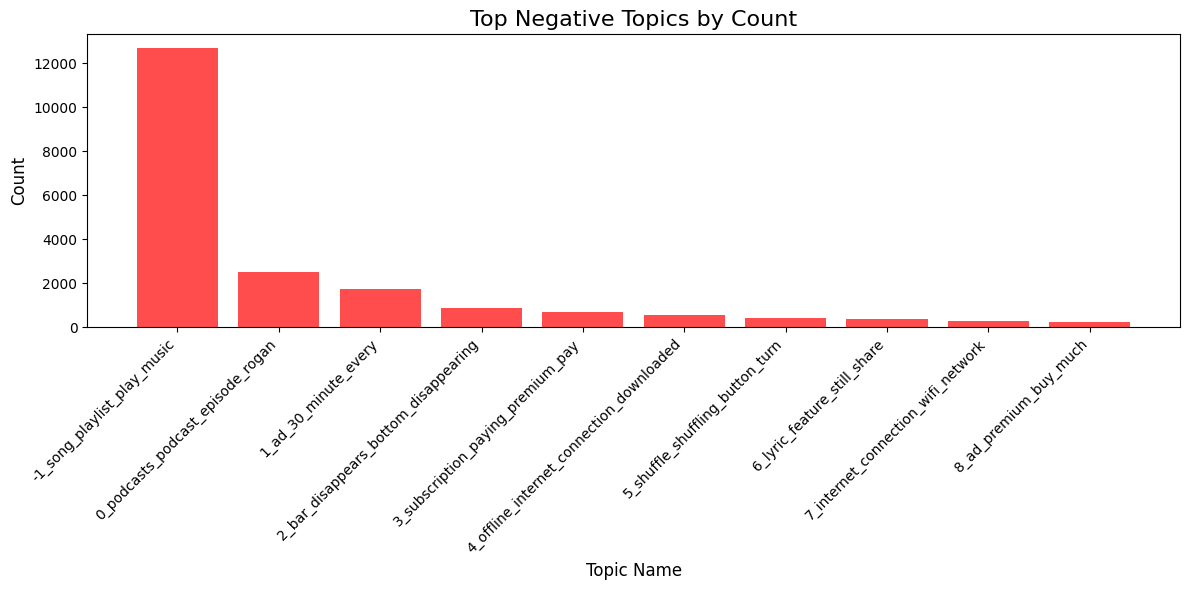

In [ ]:
# Plot สำหรับ NEGATIVE reviews
plt.figure(figsize=(12, 6))
plt.bar(negative_topics['Name'], negative_topics['Count'], color='red', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.title('Top Negative Topics by Count', fontsize=16)
plt.xlabel('Topic Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
df2 = df_1.copy()
df2.head()

,review,label,token,no_stopwords_tokens,lemmatized_tokens
0,great music service the audio is high quality ...,POSITIVE,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ...","[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating this ap...,POSITIVE,"[please, ignore, previous, negative, rating, t...","[ignore, previous, negative, rating, super, gr...","[ignore, previous, negative, rating, super, gr..."
2,this pop up get the best spotify experience on...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, experience, android, 12, anno...","[pop, get, best, experience, android, 12, anno..."
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, get, songs, put, playlist, shuffle, play]","[dear, get, song, put, playlist, shuffle, play]"


In [ ]:
df2['label'] =df2['label'].map({'POSITIVE':1,'NEGATIVE':0})
df2.head()

,review,label,token,no_stopwords_tokens,lemmatized_tokens
0,great music service the audio is high quality ...,1,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ...","[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating this ap...,1,"[please, ignore, previous, negative, rating, t...","[ignore, previous, negative, rating, super, gr...","[ignore, previous, negative, rating, super, gr..."
2,this pop up get the best spotify experience on...,0,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, experience, android, 12, anno...","[pop, get, best, experience, android, 12, anno..."
3,really buggy and terrible to use as of recently,0,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn t ...,0,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, get, songs, put, playlist, shuffle, play]","[dear, get, song, put, playlist, shuffle, play]"


In [ ]:
df2['tfidf_converted'] = df2['lemmatized_tokens'].apply(lambda x: ' '.join(x))
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df2['tfidf_converted'])
feature_names = tfidf_vectorizer.get_feature_names_out()


joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


df2.head()

,review,label,token,no_stopwords_tokens,lemmatized_tokens,tfidf_converted
0,great music service the audio is high quality ...,1,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ...","[great, music, service, audio, high, quality, ...",great music service audio high quality easy us...
1,please ignore previous negative rating this ap...,1,"[please, ignore, previous, negative, rating, t...","[ignore, previous, negative, rating, super, gr...","[ignore, previous, negative, rating, super, gr...",ignore previous negative rating super great gi...
2,this pop up get the best spotify experience on...,0,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, experience, android, 12, anno...","[pop, get, best, experience, android, 12, anno...",pop get best experience android 12 annoying le...
3,really buggy and terrible to use as of recently,0,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]",really buggy terrible use recently
4,dear spotify why do i get songs that i didn t ...,0,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, get, songs, put, playlist, shuffle, play]","[dear, get, song, put, playlist, shuffle, play]",dear get song put playlist shuffle play


In [ ]:
from sklearn.model_selection import train_test_split
X = tfidf_matrix
y = df2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#USING LOGISTIC REGRESSION

model=LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score_test = f1_score(y_test, y_pred)
print(f"Logistic Regression F-1 Score: {f1_score_test:.4f}")

Logistic Regression F-1 Score: 0.8613


In [ ]:
#USING RANDOM FOREST CLASSIFIER

model=RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score_test = f1_score(y_test, y_pred)
print(f"Random Forest Classifier F-1 Score: {f1_score_test:.4f}")

Random Forest Classifier F-1 Score: 0.8379


In [ ]:
# USING MULTINOMIAL NAIVE BAYES MODEL

model = MultinomialNB(alpha=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score_test = f1_score(y_test, y_pred)
print(f"Multinomial Naive Bayes  F-1 Score: {f1_score_test:.4f}")

Multinomial Naive Bayes  F-1 Score: 0.8383


In [ ]:

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score_test = f1_score(y_test, y_pred)
print(f"Decision Tree  F-1 Score: {f1_score_test:.4f}")

Decision Tree  F-1 Score: 0.7773


In [ ]:

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score_test = f1_score(y_test, y_pred)
print(f"XGBoost  F-1 Score: {f1_score_test:.4f}")

XGBoost  F-1 Score: 0.8294


In [ ]:
# สร้างช่วง max_iter จาก 15 ถึง 25
max_iter_values = np.arange(15, 26)

# กำหนดพารามิเตอร์ที่ต้องการจูน
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': max_iter_values,  # ใส่ช่วง max_iter ที่สร้างไว้
}

# สร้างโมเดล Logistic Regression
model = LogisticRegression()

# สร้าง GridSearchCV
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='f1',  # ใช้ F1 score เป็น metric
                           cv=5,  # 5-fold cross-validation
                           refit=True,  # ใช้โมเดลที่ดีที่สุด
                           verbose=3,  # แสดงผลการทำงาน
                           n_jobs=-1)  # ใช้หลาย core

# เรียกใช้การเทรน
grid_search.fit(X_train, y_train)

# ทำนายผลด้วยโมเดลที่ดีที่สุด
grid_predictions = grid_search.predict(X_test)

# # 5. ดูผลลัพธ์ที่ดีที่สุด
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-validation Score:", grid_search.best_score_)

# # แสดง classification report
# print(classification_report(y_test, grid_predictions))


Fitting 5 folds for each of 132 candidates, totalling 660 fits


In [ ]:
# print best parameter after tuning
print(grid_search.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid_search.best_estimator_)

{'C': 1, 'max_iter': 20, 'penalty': 'l2'}
LogisticRegression(C=1, max_iter=20)


In [ ]:
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      5864
           1       0.87      0.85      0.86      4674

    accuracy                           0.88     10538
   macro avg       0.88      0.88      0.88     10538
weighted avg       0.88      0.88      0.88     10538



In [ ]:
# 6. ประเมินผลโมเดลที่ดีที่สุดกับชุดทดสอบ
best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      5864
           1       0.85      0.81      0.83      4674

    accuracy                           0.85     10538
   macro avg       0.85      0.85      0.85     10538
weighted avg       0.85      0.85      0.85     10538



In [ ]:
joblib.dump(TfidfVectorizer(stop_words='english', max_features=10000), 'tfidf_vectorizer.pkl')

# บันทึกโมเดลที่ดีที่สุด
joblib.dump(grid_search.best_estimator_, 'best_logistic_regression_model.pkl')

['best_logistic_regression_model.pkl']